# *Analytics on Trace Data*

In this notebook we're tying to understand the Trace data, such as basic statistics and stuff. The aim of this notebook in the end is to _collapse the equal-cost multipaths_ or something sround that to reduce the complexity of the data. We here in this notebook look at distributions of data to understand the generalnature of trace data. 

We'll be pulling data from Kibana using the ElasticSearch Python API and plotting some data for easier understanding, we only use the data in production not the test data.


In [3]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from time import time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt

#### *Custom Modules*
We use two custom modules which assist us. 

The first module contains various types of queries callable as functions and the other module is a utility module for plotting, getting correct date formats etc..

(The auto-reload extension, always reloads the modules without having the need to restart the IPython Kernel. Helps a lot in development of custom modules like these.)

In [48]:
%load_ext autoreload
%autoreload 2

import Utility_Modules.r_utils as ut
import Utility_Modules.elasticqueries as qrs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### *Conecting to ElasticSearch*
This connection object work throughout the notebook to retreive data from the ElasticSearch Kibana Instance

Enter your user and passwd fields to connect to the database. Change from None to String type

In [5]:
user = None
passwd = None
if user is None and passwd is None:
    with open("creds.key") as f:
        user = f.readline().strip()
        passwd = f.readline().strip()
credentials = (user, passwd)
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'], timeout=90, http_auth=credentials)

print("Connection Successful") if es.ping() == True else print("Connection Unsuccessful")

Connection Successful


------
### *Distinct Counts*

In the next cell we inspect the **count of distinct values** (Fields Specified Below) in the ps trace data in the last 90 day time frame to get some insights on the data.


* dest_host
* src_host
* dest
* src
* dest_site
* src_site

**\***
There is an aditional function present here *__getUniqueCountBy()__* which returns a list of the unique values and not just the length. Although, it prints out the size of the array when executing. It takes in the same argument as the function below.


In [6]:
countOf = ['dest_host', 'dest', 'src_host', 'src','src_site', 'dest_site']
for i in countOf:
    print("{:9s} : {:4d}".format(i, qrs.getUniqueCount(es,'ps_trace',i)))

dest_host :  818
dest      :  948
src_host  :  491
src       :  556
src_site  :  121
dest_site :  129


### *Looking at the Numbers Above*

**Q :** Why is the number of ip's per site more than 1 (we see upto 7 here)

**A :** "Site" is typically equivalent to a WLCG Tier-2.  Some of our Tier-2s actually are composed of more than one institution.  Each distinct network location (different subnet for example) should have two different perfSONAR toolkits installed; one for latency measurement and one for bandwidth measurement.   A typical "site" at only one institution, should have 2 different IPs; one for latency and one for bandwidth.  A site can have multiple networks to monitor and can therefore have multiple associated IPs

**Q :** Why are there 2 or more ips per hostname

**A :** Some perfSONAR instances have both IPv4 and IPv6 addresses.  This is called being dual-stacked.   That is ONE way to have multiple IP addresses for a specific perfSONAR toolkit instance.   It is also possible to add more IP addresses (which may end up testing different data paths through the network).  Each interface could have additional IP addresses added, either IPv4 or IPv6.  Usually additional IPv4/IPv6 addresses (beyond the first) would be added into specific different VLANs.


**Q :** Why are there more dest_hosts than src_hosts

**A :**

**\*** Thanks **Shawn McKee** for helping answer these questions.

-----
**Frequency Distribution of Source and Destination Hosts **

In [7]:
src_data = qrs.getUniqueCountBy(es,'ps_trace','src_host')
dest_data = qrs.getUniqueCountBy(es,'ps_trace','dest_host')

Size : 491
Size : 818


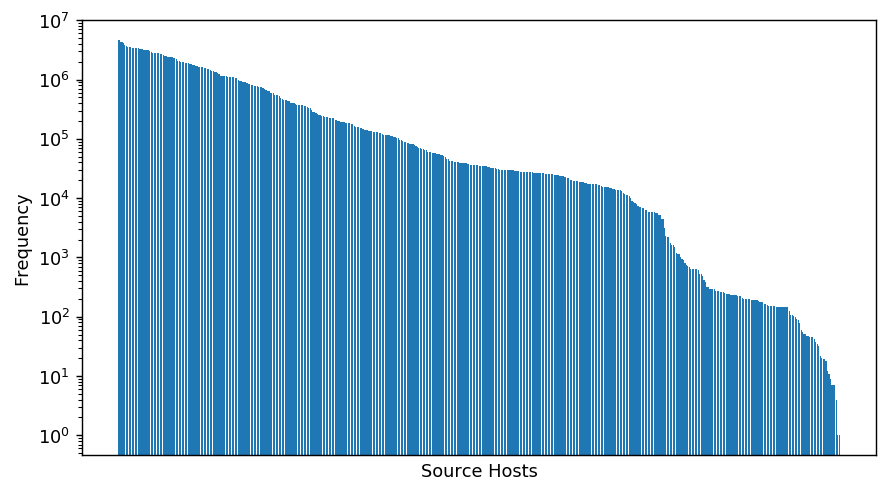

In [49]:
ut.plotByHist(src_data,"Source Hosts",plt)

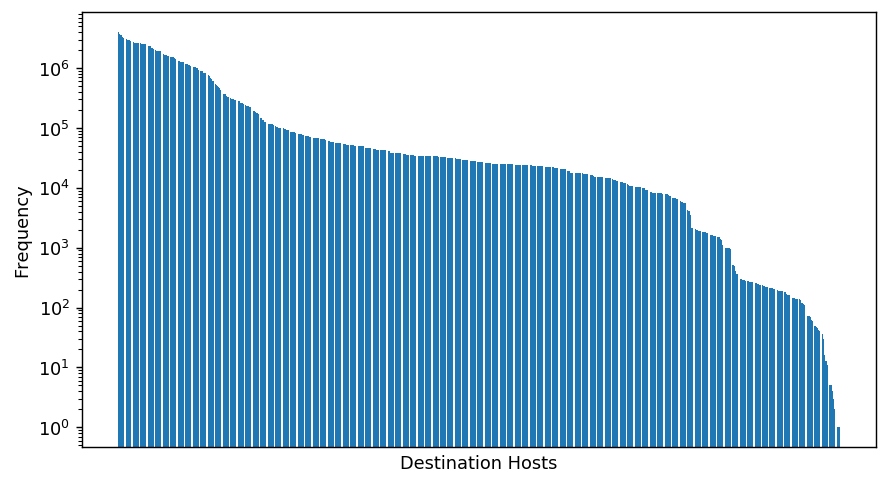

In [50]:
ut.plotByHist(dest_data, 'Destination Hosts', plt)

### *Conclusion*
This helps us see that all the sources do not talk all the destinations and some talk to more than the others. The reason behind this is the mesh architecture. All the hosts present in the mesh talk to every other host in the mest but not outside the mesh. And some nodes are associated with more meshes than others.

-----
### *Frequency Distribution of Paths between all pair of nodes (in the past three weeks from today)*

We use the results captured another script here for this usecase, which is also placed in the Utility_Modules folder.
That script provides us with two values of our interest, total path between a source and destination and number of paths whihc were take more than once. We did this to reduce the complexity in our data and maybe look it as an alternative to removing equal cost multipaths. 

In [54]:
src_dest_path_df = pd.read_csv("Results/SourceDestinationPairs.csv")

##### **Mean** and **Standard Deviation** of #Paths between nodes across a 21 day period.  

In [6]:
print('Mean : ', src_dest_df['NumPaths'].mean())
print('Std. Dev : ', np.sqrt(src_dest_df['NumPaths'].var()))

Mean :  33.01052631578948
Std. Dev :  127.88608191906852


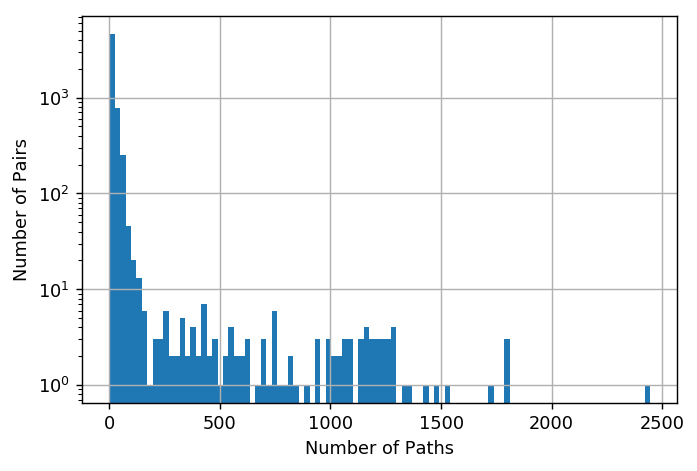

In [7]:
plt.figure(dpi=128)
src_dest_df['NumPaths'].hist(bins=100)
plt.xlabel("Number of Paths")
plt.ylabel("Number of Pairs")
plt.yscale("log")


<Figure size 1536x1024 with 0 Axes>

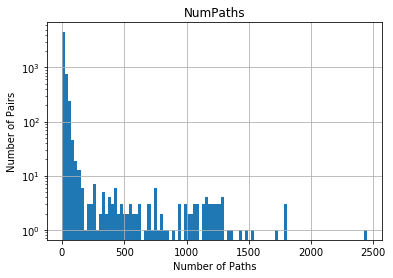

In [9]:
plt.figure(dpi=256)
src_dest_df[src_dest_df['NumPaths'] > 1].hist(bins=100)
plt.xlabel("Number of Paths")
plt.ylabel("Number of Pairs")
plt.yscale("log")

In [22]:
ut.getDateFormat(delta=7)

'1562013135781.979'

hepsonar1.ph.liv.ac.uk perfsonar-bandwidth.grid.pub.ro
ps02-b.farm.particle.cz atlas-npt2.bu.edu
psmsu02.aglt2.org ps001.gla.scotgrid.ac.uk
perfsonar-grid.uaic.ro perfsonar-de-kit.gridka.de
perfsonar-grid.uaic.ro mwt2-ps02.campuscluster.illinois.edu
psb01.pic.es perfsonar2.ihepa.ufl.edu
ps001.gla.scotgrid.ac.uk perfsonar-bandwidth.grid.pub.ro


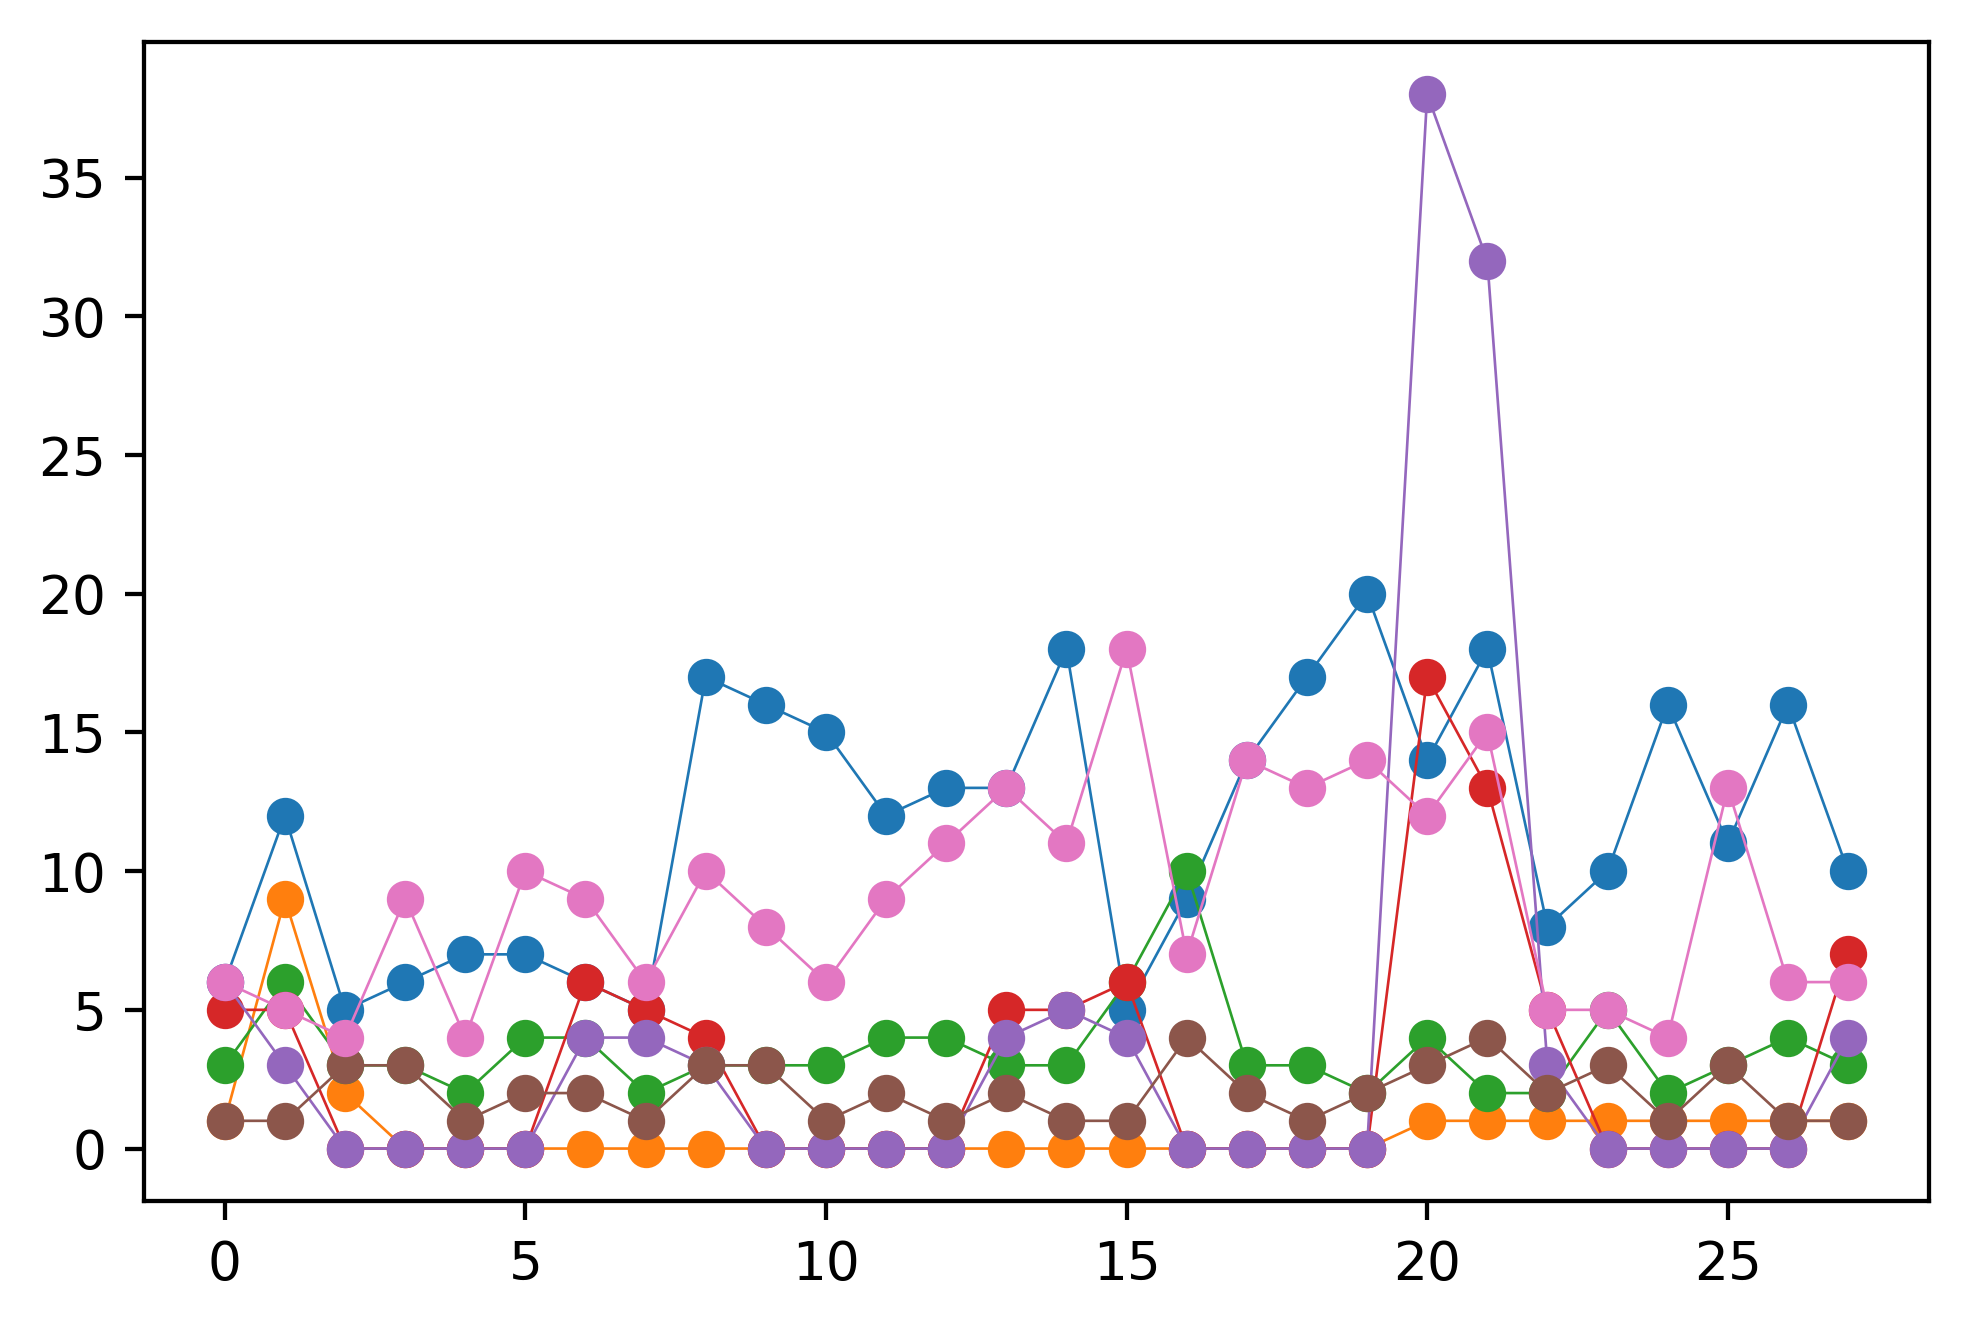

In [15]:
n_samples = 7
smpls = src_dest_df.sample(n=n_samples)
results = [[] for i in range(n_samples)]
j = 0
n_days = 28
plt.figure(dpi=384)
for i,r in smpls.iterrows():
    print(r.Source, r.Destination)
    days = qrs.getDailyUniquePaths(es, 'ps_trace', r.Source, r.Destination,n_days)
    for day in days['aggregations']['time_hist']['buckets']:
        results[j].append(day['uniq_hash']['value'])
    plt.plot(results[j], linewidth=0.5, marker='o',label = r.Source + " > " + r.Destination)
    j += 1

# plt.legend()

`Make global average histograms`

`June 27, 2019`

In [ ]:
def getPaths(es, src, dest, since=1):
    
    toDate = getDateFormat(1)
    fromDate = getDateFormat(since+1)

    query = {
        "_source":{
            "includes":['hops']
        },
        "size":5000,
        "query":{
            "bool": {
              "must": [
                {
                  "range": {
                    "timestamp": {
                      "gte": fromDate,
                      "lte": toDate,
                      "format": "epoch_millis"
                    }
                  }
                },
                {
                  "term": {
                    "src_host": {
                      "value": src
                    }
                  }
                },
                {
                  "term": {
                    "dest_host": {
                      "value": dest
                    }
                  }
                }
              ]
            }
        }
    }
       
    init_res =  es.search(index='ps_trace', body=query, request_timeout=30)  
    results = []
    for res in init_res['hits']['hits']:
        results.append(res['_source']['hops'])
    
    return results

In [ ]:
rsmple = src_dest_df.sample(n=1)
print("Source : ", rsmple.iloc[0,0])
print("Destination : ", rsmple.iloc[0,1])

paths = getPaths(es, rsmple.iloc[0,0], rsmple.iloc[0,1], 7)

host_id = dict()
num_ids = 1
for path in paths:
    for i in range(len(path)):
        try:
            hid = host_id[path[i]]
            path[i] = hid
        except:
            host_id[path[i]] = num_ids
            path[i] = num_ids
            num_ids += 1

plt.figure(dpi=512)
m_size = 2
for path in paths:
    plt.plot(path,'---.',markersize=m_size, marker='o', linewidth=0.6)
#     m_size -= 0.2
# plt.legend()
print("Num Paths: ", len(paths))

**Ask Shawn**

1. Circular Paths

ADD LABELS EVERYWHERE
DOCUMENTATION
MAKE IT READABLE
WAY MORE

FOR ANOMAILES, find max number of different paths, different paths of euqal costs
and how often these nodes appear in different paths.

Get Nodes only 3 hops apart

Total number of unique ips, and hops

Source :  perfsonar-ps2.ndgf.org
Destination :  ps-gsdc02.sdfarm.kr
Num Paths:  974

In [ ]:
datetime(2019,6,1)

### TODO: 
Exclude: Test from everything

Add timerange, past 3 months everywhere.

Add mean, variance and stats in legend